## 1. Escolher uma das colunas dos dados utilizados no projeto 1 para predição (classificação ou regressão)

In [62]:
# !pip install mlflow
# !pip install --upgrade setuptools
# !pip install scikit-optimize
# !pip install xgboost
# !pip install shap

In [63]:
import pandas as pd
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

import shap

import mlflow.pyfunc
import os

In [64]:
path_raw = os.getenv('PATH_RAW')
# df_raw = pd.read_csv('scraped_data.csv', sep=',')
df_raw = pd.read_csv('../scraped_data.csv', sep=',', nrows=1000)

In [65]:
df_raw.head(1)

,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,...,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
0,Apartamento para venda com 105 metros quadrado...,R$ 1.100 / mês,Código do anúncio: C6BAD9\n\nO apartamento est...,"Aflitos, Recife, PE, 52050340",R$ 180,Rua da Angustura,105m²,380000,Antônio Luciano Santana da Silva,False,...,False,False,False,True,False,False,3,20,0,3


In [66]:
df_0 = df_raw.copy()

In [67]:
df_0 = df_0.drop(columns=['find_anuncio','find_descri']) 

df_0 = df_0[df_0['n_quartos'] != '5 ou mais'] # por recomendação do professor
df_0 = df_0[df_0['n_banheiros'] != '5 ou mais']
df_0 = df_0[df_0['n_garagens'] != '5 ou mais']

df_0[['Bairro','CEP']] = df_0['find_endereco'].str.split(', ', expand=True)[[0,3]]
df_0 = df_0.drop(columns=['find_endereco'])

In [68]:
# deixando como num a coluna find_condominio
df_0['find_condominio'] = df_0['find_condominio'].astype('str').str.replace('R$', '').str.replace(' / mês', '').str.replace('.', '')

# deixando como num a coluna find_iptu
df_0['find_iptu'] = df_0['find_iptu'].astype('str').str.replace('R$ ', '').str.replace('.', '')

# deixando como num a coluna find_m_quadrado
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('str').str.replace('m²', '').str.replace('.', '')

# cast direto colunas(floats devido a conseguir dar cast em NaN)
df_0['find_condominio'] = df_0['find_condominio'].astype('float')
df_0['Bairro'] = df_0['Bairro'].astype('category')
df_0['CEP'] = df_0['CEP'].astype('category')
df_0['find_iptu'] = df_0['find_iptu'].astype('float')
df_0['find_loc'] = df_0['find_loc'].astype('category')
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('float')
df_0['find_price'] = df_0['find_price'].astype('float')
df_0['find_vendedor'] = df_0['find_vendedor'].astype('category')
df_0['is_academia'] = df_0['is_academia'].astype('category')
df_0['is_apertamento'] = df_0['is_apertamento'].astype('category')
df_0['is_ar_condicionado'] = df_0['is_ar_condicionado'].astype('category')
df_0['is_churrasqueira'] = df_0['is_churrasqueira'].astype('category')
df_0['is_elevador'] = df_0['is_elevador'].astype('category')
df_0['is_mobiliado'] = df_0['is_mobiliado'].astype('category')
df_0['is_piscina'] = df_0['is_piscina'].astype('category')
df_0['is_portaria'] = df_0['is_portaria'].astype('category')
df_0['is_profissional'] = df_0['is_profissional'].astype('category')
df_0['is_salao_festa'] = df_0['is_salao_festa'].astype('category')
df_0['is_varanda'] = df_0['is_varanda'].astype('category')
df_0['n_banheiros'] = df_0['n_banheiros'].astype('float')
df_0['n_fotos'] = df_0['n_fotos'].astype('float')
df_0['n_garagens'] = df_0['n_garagens'].astype('float')
df_0['n_quartos'] = df_0['n_quartos'].astype('float')

In [69]:
df_0[df_0.select_dtypes(['category']).columns] = df_0.select_dtypes(['category']).apply(lambda x: x.cat.codes)

In [70]:
df_0 = df_0.drop_duplicates()

In [71]:
from fancyimpute import KNN

df_0_knn = KNN(k=2).fit_transform(df_0)

Imputing row 1/918 with 0 missing, elapsed time: 0.168
Imputing row 101/918 with 0 missing, elapsed time: 0.169
Imputing row 201/918 with 0 missing, elapsed time: 0.169
Imputing row 301/918 with 0 missing, elapsed time: 0.169
Imputing row 401/918 with 0 missing, elapsed time: 0.169
Imputing row 501/918 with 0 missing, elapsed time: 0.170
Imputing row 601/918 with 0 missing, elapsed time: 0.170
Imputing row 701/918 with 0 missing, elapsed time: 0.170
Imputing row 801/918 with 0 missing, elapsed time: 0.171
Imputing row 901/918 with 0 missing, elapsed time: 0.171


In [72]:
df_0 = pd.DataFrame(data=df_0_knn[0:,0:],columns=df_0.columns)
df_0.isna().sum()

find_condominio       0
find_iptu             0
find_loc              0
find_m_quadrado       0
find_price            0
find_vendedor         0
is_academia           0
is_apertamento        0
is_ar_condicionado    0
is_churrasqueira      0
is_elevador           0
is_mobiliado          0
is_piscina            0
is_portaria           0
is_profissional       0
is_salao_festa        0
is_varanda            0
n_banheiros           0
n_fotos               0
n_garagens            0
n_quartos             0
Bairro                0
CEP                   0
dtype: int64

In [73]:
df_0.head(1)

,find_condominio,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,...,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,Bairro,CEP
0,1100.0,180.0,365.0,105.0,380000.0,26.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,20.0,0.0,3.0,0.0,305.0


In [74]:
df_1 = df_0.copy()

vamos escolher a coluna de preço para fazer regressão

In [75]:
y = df_1['find_price']

In [76]:
X = df_1.drop(columns=['find_price'])

## 2. Separar os dados em treinamento, validação e teste
    - Escolhemos seguir com as proporções 
        - 70:30 para treino:teste  
        - 80:20 para o treino:valid

In [77]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

## 3. Selecionar 4 algoritmos de acordo com a tarefa escolhida no passo 1

In [78]:
from sklearn.svm import SVR
svr = SVR()

In [79]:
from sklearn.ensemble  import RandomForestRegressor
rfr = RandomForestRegressor()

In [80]:
from xgboost import XGBRegressor
xgbm = XGBRegressor()

In [81]:
from sklearn.neighbors  import KNeighborsRegressor
knnr = KNeighborsRegressor()

## 4. Adicionar MLFlow no treinamento dos modelos para rastreamento

In [82]:
import mlflow
import mlflow.sklearn

In [83]:
mlflow.set_experiment("exp_edu_0")

<Experiment: artifact_location='file:///c:/Users/davim/OneDrive/Desktop/playground/scraping/notebook_analysis/mlruns/886108216977638183', creation_time=1720645381456, experiment_id='886108216977638183', last_update_time=1720645381456, lifecycle_stage='active', name='exp_edu_0', tags={}>

## 5. Executar uma ferramenta de seleção de hiper-parâmetros sobre o conjunto de validação

Executar o melhor modelo de cada algoritmo no conjunto de teste e
selecionar o melhor modelo geral na métrica de avaliação

In [84]:
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

In [85]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

Selecionar poucos hiper-parâmetros por algoritmo (max. 3)

#### Support Vector Regression

In [86]:
from sklearn.preprocessing import StandardScaler

In [87]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

search_space = {
    'C': (1e-6, 1e+6, 'log-uniform'), 
    'epsilon': (1e-6, 1e+1, 'log-uniform'),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

opt = BayesSearchCV(
    estimator=svr,
    search_spaces=search_space,
    n_iter=15,  
    cv=kfold,
    scoring=mse_scorer,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_val_scaled, y_val)

best_model_svr = SVR(**opt.best_params_)
print("Best parameters found: ", opt.best_params_)

Best parameters found:  OrderedDict({'C': 978592.0225563409, 'epsilon': 1e-06, 'kernel': 'linear'})


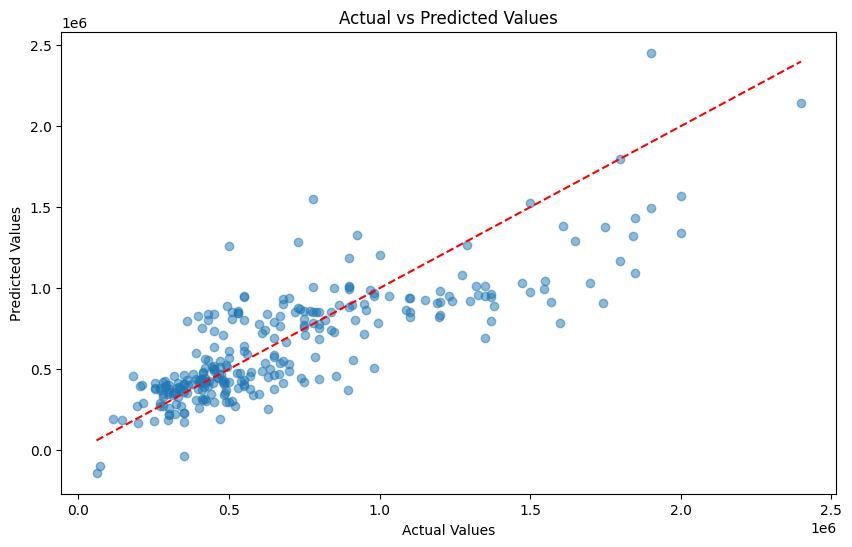

Root Mean Squared Error: 249156.72990582726


In [88]:
# Start an MLflow run
with mlflow.start_run(run_name="SVM"):
    # Log parameters
    mlflow.log_params(opt.best_params_)

    best_model_svr.fit(X_train_scaled,y_train)

    y_pred = best_model_svr.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlflow.log_metric('RMSE', rmse)

    mlflow.sklearn.log_model(best_model_svr, 'model')


    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    plot_file = "sample_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file, artifact_path="plots")

    plt.show()

    print(f'Root Mean Squared Error: {rmse}')

#### Random forest

c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['poisson', 'log2'] before, using random point ['friedman_mse', 'sqrt']
  warnings.warn(
c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['poisson', 'log2'] before, using random point ['squared_error', 'sqrt']
  warnings.warn(
c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['poisson', 'log2'] before, using random point ['squared_error', 'sqrt']
  warnings.warn(


Best parameters found:  OrderedDict({'criterion': 'poisson', 'max_features': 'log2'})


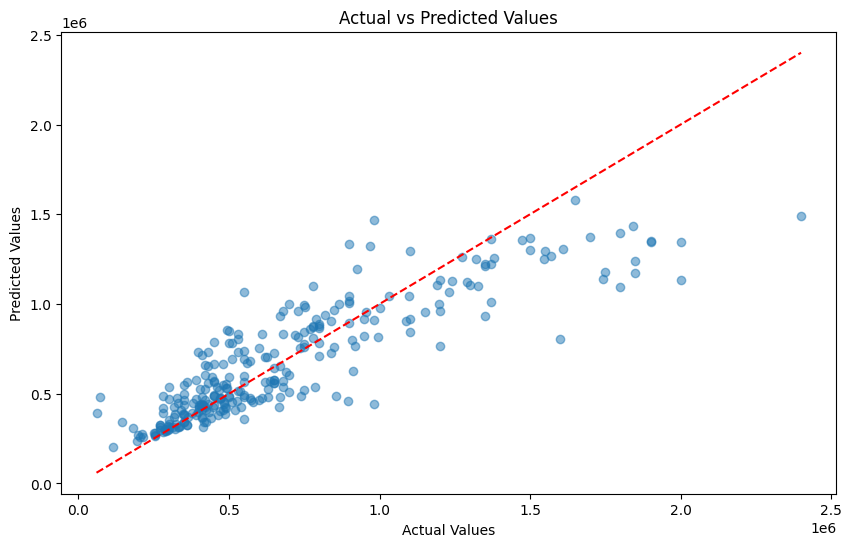

Root Mean Squared Error: 213651.92664485736


In [89]:
search_space = {
    'criterion': ("squared_error", "absolute_error", "friedman_mse", "poisson"), 
    'max_features':("sqrt", "log2") 
}

opt = BayesSearchCV(
    estimator=rfr,
    search_spaces=search_space,
    n_iter=15,  
    cv=kfold,
    scoring=mse_scorer,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_val, y_val)


best_model_rfr = RandomForestRegressor(**opt.best_params_)
print("Best parameters found: ", opt.best_params_)

with mlflow.start_run(run_name="RandomForestRegressor"):
    mlflow.log_params(opt.best_params_)

    best_model_rfr.fit(X_train,y_train)
    y_pred = best_model_rfr.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlflow.log_metric('RMSE', rmse)

    mlflow.sklearn.log_model(best_model_rfr, 'model')

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    plot_file = "sample_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file, artifact_path="plots")

    plt.show()

    print(f'Root Mean Squared Error: {rmse}')

#### XGboost

Best parameters found:  OrderedDict({'learning_rate': 0.15849201309311142, 'max_depth': 4, 'n_estimators': 319})


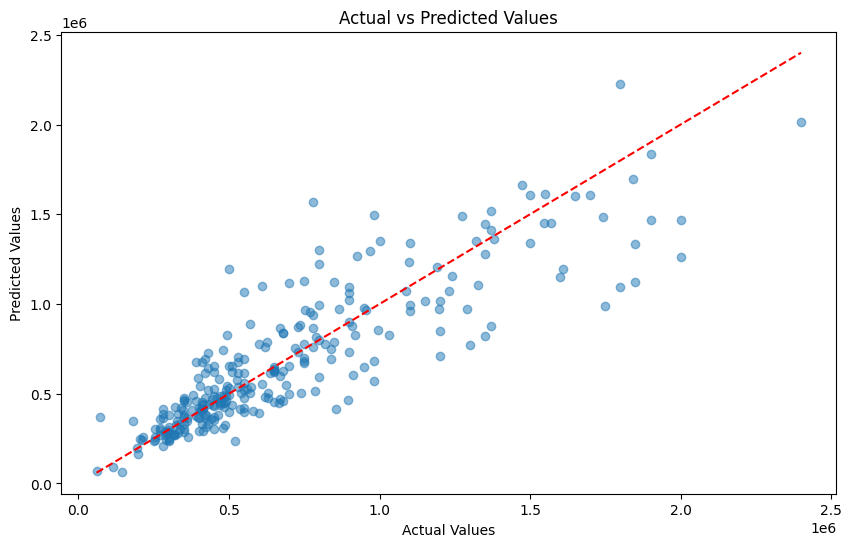

Root Mean Squared Error: 209602.6207191535


In [90]:
search_space = {
    'learning_rate': (0.01, 0.3, 'log-uniform'), 
    'max_depth': (3, 10), 
    'n_estimators': (50, 500)
}

opt = BayesSearchCV(
    estimator=xgbm,
    search_spaces=search_space,
    n_iter=15,  
    cv=kfold,
    scoring=mse_scorer,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_val, y_val)

best_model_xgbm = XGBRegressor(**opt.best_params_, random_state=42)

print("Best parameters found: ", opt.best_params_)

with mlflow.start_run(run_name="XGBRegressor"):
    mlflow.log_params(opt.best_params_)

    best_model_xgbm.fit(X_train,y_train)

    y_pred = best_model_xgbm.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlflow.log_metric('RMSE', rmse)

    mlflow.sklearn.log_model(best_model_xgbm, 'model')


    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    plot_file = "sample_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file, artifact_path="plots")

    plt.show()

    print(f'Root Mean Squared Error: {rmse}')


#### knn

Best parameters found:  OrderedDict({'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'})


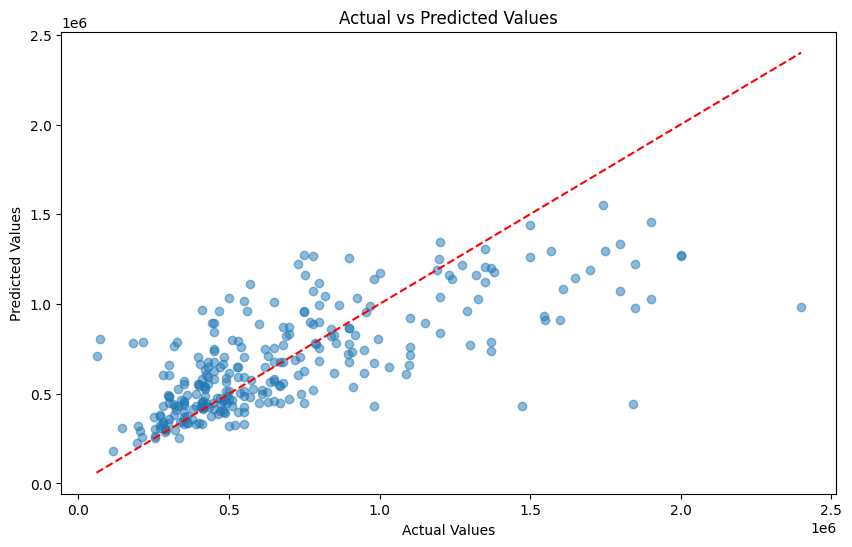

Root Mean Squared Error: 293292.75393638737


In [91]:
search_space = {
    'n_neighbors': (1, 50),
    'weights': ('uniform', 'distance'),
    'metric': ('euclidean', 'manhattan', 'minkowski')
}

opt = BayesSearchCV(
    estimator=knnr,
    search_spaces=search_space,
    n_iter=15,
    cv=kfold,
    scoring=mse_scorer,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_val, y_val)

best_model_knnr = KNeighborsRegressor(**opt.best_params_)

print("Best parameters found: ", opt.best_params_)

with mlflow.start_run(run_name="KNeighborsRegressor"):
    mlflow.log_params(opt.best_params_)

    best_model_knnr.fit(X_train, y_train)
    y_pred = best_model_knnr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlflow.log_metric('RMSE', rmse)
    mlflow.sklearn.log_model(best_model_knnr, 'model')

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    plot_file = "sample_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file, artifact_path="plots")

    plt.show()

    print(f'Root Mean Squared Error: {rmse}')


### Selecionar o modelo (algoritmo+valores de hiper-parâmetros) com melhor resultado na métrica de avaliação
    - o Xgboost foi o que teve menor RMSE (209602.6207191535) 
    

In [94]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, best_model_xgbm.predict(X_test)))}')

RMSE: 209602.6207191535


### Supor Vector Machine foi o terceiro melhor modelo:

#### C (parâmetro de regularização):
Valor: 978592.0225563409
Comente:
O parâmetro C controla a compensação entre obter um erro baixo nos dados de treinamento e minimizar a complexidade do modelo.
Um valor alto de C indica que o modelo prioriza a minimização do erro de treinamento, potencialmente com risco de overfitting.
Neste caso, C é bastante grande, sugerindo que o modelo está penalizando fortemente qualquer classificação incorreta ou erro nos dados de treinamento.

#### Épsilon (ε):
Valor: 1e-06
Comente:
O parâmetro épsilon especifica uma margem de tolerância onde nenhuma penalidade é aplicada por erros.
Um valor muito pequeno de épsilon (como 1e-06) indica que o modelo visa uma precisão muito alta, tentando minimizar qualquer desvio dos valores reais.
Isto pode levar a um ajuste muito apertado aos dados de treinamento, possivelmente levando a um overfitting.

#### Kernel:
Valor: 'linear'
Comente:
O parâmetro do kernel determina o tipo de limite de decisão que o algoritmo usa para separar diferentes classes ou prever valores.
Um kernel linear implica que o relacionamento entre os recursos de entrada e a variável de destino é considerado linear.
Esta é a forma mais simples de SVR, que encontra um hiperplano linear (em um espaço de alta dimensão) que melhor se ajusta aos dados.

In [95]:
best_model_svr.get_params()

{'C': 978592.0225563409,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 1e-06,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Random florest teve o segundo melhor resultado:

#### criterion: 'squared_error':
Este parâmetro indica o critério usado para medir a qualidade de uma divisão no processo de criação das árvores na floresta aleatória.
'squared_error' (ou 'mean squared error' - MSE) é um critério comum para problemas de regressão, pois mede o quadrado da diferença entre os valores previstos e os valores reais. Ele busca minimizar o erro quadrático médio, o que geralmente leva a modelos mais precisos para previsão de valores contínuos.

#### max_features: 'sqrt':
Este parâmetro define o número de recursos (features) a serem considerados ao procurar a melhor divisão em cada nó da árvore.
'sqrt' significa que o número máximo de features a serem consideradas em cada divisão é a raiz quadrada do número total de features. Esta configuração é bastante comum e recomendada, pois ajuda a reduzir a correlação entre as árvores, aumentando a diversidade do ensemble e, consequentemente, a performance geral do modelo.

In [96]:
best_model_rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'poisson',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### XGBoost, foi o melhor modelo:

#### learning_rate (taxa de aprendizado) = 0.15849201309311142:
A taxa de aprendizado controla o tamanho dos passos que o modelo dá ao ajustar os pesos com base nos gradientes. Um valor de aproximadamente 0.158 indica que o modelo está fazendo atualizações moderadamente pequenas, o que pode ajudar a evitar overfitting e a garantir uma convergência mais suave e estável. Valores muito altos podem levar a um aprendizado rápido, mas com risco de não alcançar um ótimo global, enquanto valores muito baixos podem resultar em um treinamento muito lento.

#### max_depth (profundidade máxima) = 4:
A profundidade máxima do árvore controla a complexidade do modelo. Uma profundidade de 4 é relativamente rasa, o que pode ajudar a prevenir overfitting, pois árvores mais profundas podem memorizar os dados de treinamento. Este valor sugere que o modelo está sendo restringido para capturar padrões importantes sem se tornar excessivamente complexo.

#### n_estimators (número de estimadores) = 319:
O número de estimadores refere-se ao número de árvores na floresta. Ter 319 árvores é um número substancial, indicando que o modelo está agregando um número suficiente de árvores para melhorar a performance por meio do ensemble learning. No entanto, este número também deve ser balanceado com o tempo de treinamento e a possibilidade de overfitting.

In [97]:
best_model_xgbm.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.15849201309311142,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 319,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### KNN, foi o quarto lugar:

#### Métrica (metric): 'manhattan':
A métrica Manhattan, também conhecida como métrica de distância de Manhattan ou métrica L1, calcula a distância entre dois pontos como a soma das diferenças absolutas de suas coordenadas. Em outras palavras, é a distância percorrida em um grid retangular (como andar pelas ruas de uma cidade disposta em forma de grade, daí o nome). Esta métrica é útil quando as características (features) do seu conjunto de dados têm diferentes escalas ou quando se espera que os dados estejam distribuídos de maneira a que a diferença em cada dimensão seja importante.

#### Número de vizinhos (n_neighbors): 11:
O parâmetro n_neighbors define o número de vizinhos mais próximos a serem considerados para fazer a predição. Com 11 vizinhos, o modelo KNN irá olhar para os 11 pontos mais próximos do ponto que está sendo previsto e usar suas informações para calcular a resposta. Um número maior de vizinhos pode ajudar a suavizar a predição e reduzir o efeito de ruído, mas também pode fazer o modelo perder algumas das variações locais dos dados.

#### Pesos (weights): 'distance':
O parâmetro weights determina como a contribuição de cada um dos vizinhos é ponderada. Usando 'distance', o modelo atribui pesos maiores aos vizinhos mais próximos do ponto de interesse, de modo que os vizinhos mais próximos têm uma influência maior na predição do que os mais distantes. Isto pode ajudar a melhorar a precisão da predição, especialmente em casos onde a proximidade espacial (segundo a métrica escolhida) é um indicador forte da similaridade dos pontos.

In [98]:
best_model_knnr.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 11,
 'p': 2,
 'weights': 'distance'}

## 6. Realizar diagnóstico do melhor modelo geral da etapa 5 e melhorá-lo a partir do diagnóstico

In [99]:
shap.initjs()

In [100]:
masker = shap.maskers.Independent(X_test)
explainer = shap.Explainer(best_model_xgbm.predict, masker)
shap_values = explainer(X_test)

PermutationExplainer explainer: 277it [01:51,  2.33it/s]                         


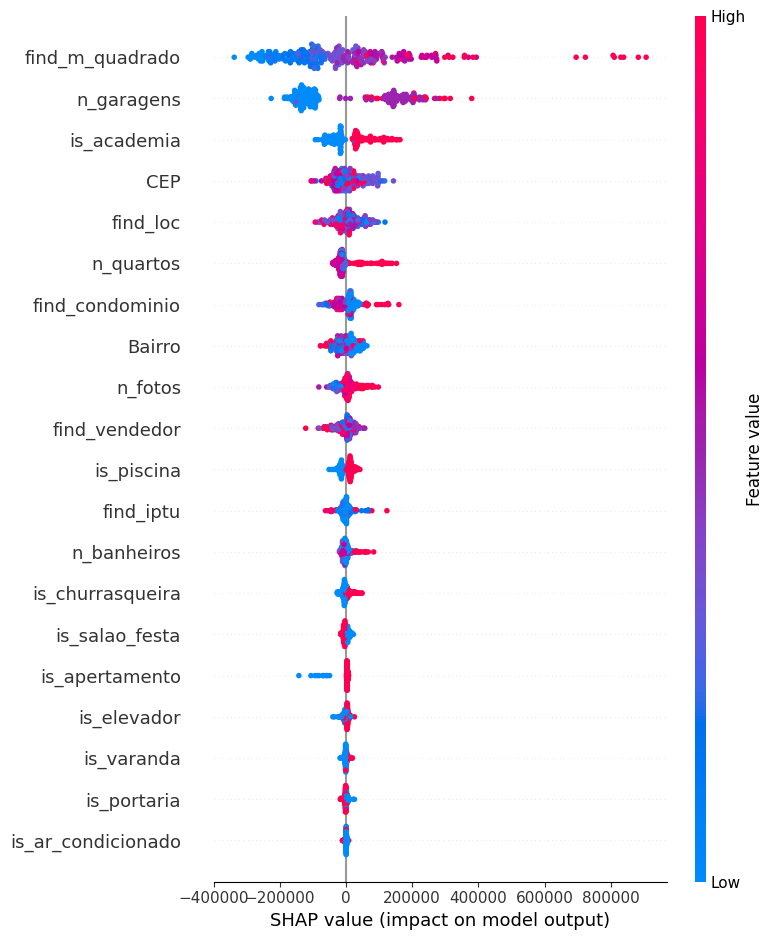

In [101]:
shap.summary_plot(shap_values.values, X_test, plot_type="dot")

vamos olhar para o top3 variáveis com maior importância

In [102]:
top_3_vars = ['find_m_quadrado', 'n_garagens', 'is_academia']

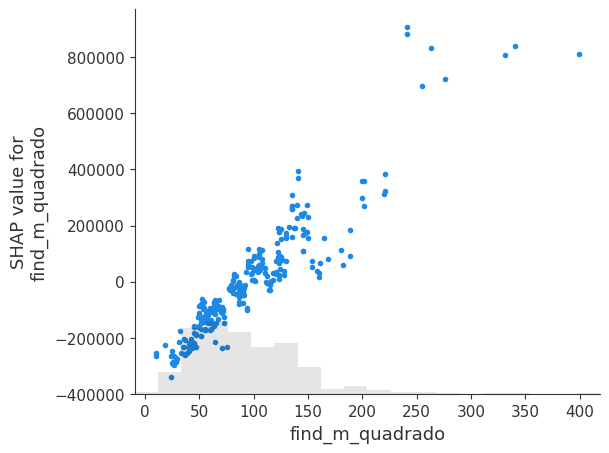

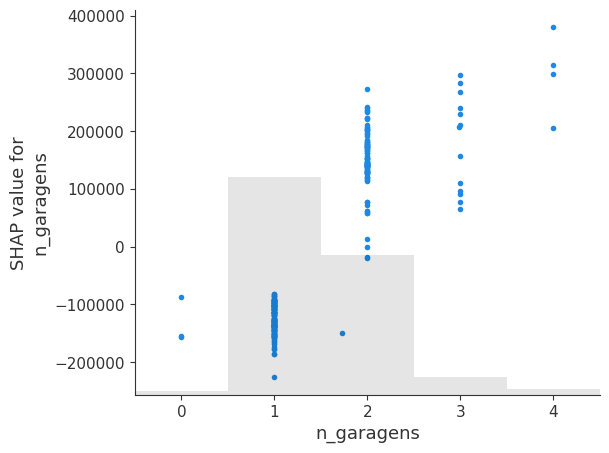

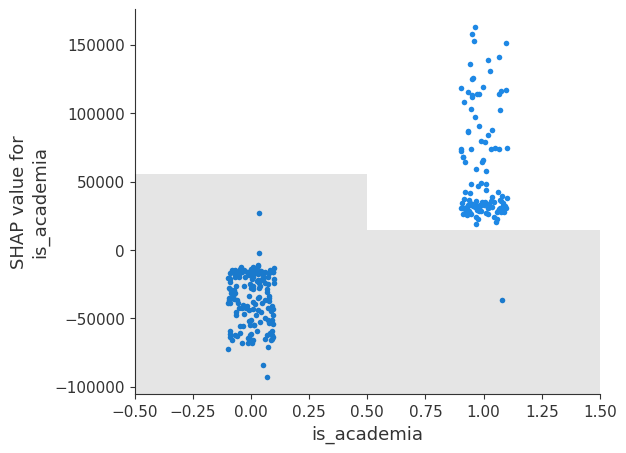

In [103]:
for var in top_3_vars:
    shap.plots.scatter(shap_values[:, var])

In [104]:
X_test['find_price'] = y_test  

quintile_analysis = {}
for var in top_3_vars:
    if X_test[var].nunique() > 10:
        X_test['quintile'] = pd.qcut(X_test[var], 5, labels=False, duplicates='drop')
        quintile_means = X_test.groupby('quintile')['find_price'].mean().reset_index()
        quintile_means.columns = ['quintile', 'mean_find_price']
    else:
        quintile_means = X_test.groupby(var)['find_price'].mean().reset_index()
        quintile_means.columns = [var, 'mean_find_price']
    quintile_analysis[var] = quintile_means
    if 'quintile' in X_test.columns:
        X_test.drop(columns='quintile', inplace=True)

for var in top_3_vars:
    print(f"Análise Bivariada para a variável: {var}")
    print(quintile_analysis[var])
    print("\n")

Análise Bivariada para a variável: find_m_quadrado
   quintile  mean_find_price
0         0     3.329466e+05
1         1     4.901202e+05
2         2     6.453883e+05
3         3     8.225601e+05
4         4     1.197692e+06


Análise Bivariada para a variável: n_garagens
   n_garagens  mean_find_price
0    0.000000     1.600000e+05
1    1.000000     3.990000e+05
2    1.000000     4.532526e+05
3    1.727866     4.500000e+05
4    2.000000     9.370242e+05
5    2.989028     1.290000e+06
6    3.000000     1.517075e+06
7    4.000000     1.650000e+06


Análise Bivariada para a variável: is_academia
   is_academia  mean_find_price
0          0.0    646668.753165
1          1.0    748049.059322




Olhando para a análise bivariada, conseguimos ver uma tendência geral que:

    - Quanto maior o m², maior a média do preço do imóvel.
    - Quanto maior a quantidade de garagens, maior a média do preço do imóvel.
    - Quando tem academia, maior a média do preço do imóvel.

E quando olhamos para o SHAP (análise olhando tanto para o gráfico de beeswarm quanto para o dependence plot):

    - Quanto maior o m², maior os valores SHAP (maior os valores de saída do modelo, ou seja, maior o preço do imóvel que o modelo dá como saída).
    - Quanto maior a quantidade de garagens, maior os valores SHAP (maior os valores de saída do modelo, ou seja, maior o preço do imóvel que o modelo dá como saída).
    - Quando tem academia, maior os valores SHAP (maior os valores de saída do modelo, ou seja, maior o preço do imóvel que o modelo dá como saída).
    
Vimos que tanto na análise bivariada com o alvo quanto olhando para os valores SHAP, concordamos na sua tendência, ponto positivo mostrando que o modelo está reproduzindo o comportamento esperado dessas variáveis para a base de teste.